# Sistemas Recomendadores: Content based

Germán Cheuque

## Setup

**Paso 1:** Descarga de archivos que serán utilizados posteriormente.

*   Recursos:
  * `dictionary.p`
  * `dictionary-stemm.p`
  * `tfidf_model.p`
  * `tfidf_model-stemm.p`
*   Dataset:
  *  `corpus1.csv`

In [ ]:
# Descarga de recursos
!curl -L -o 'resources.tar.gz' 'https://github.com/PUC-RecSys-Class/Syllabus/blob/master/Practico%204/files/resources.tar.gz?raw=true'

# Descompresión del archivo
!tar -xvf resources.tar.gz

In [2]:
# Descarga del dataset
!curl -L -o 'dataset.tar.gz' 'https://github.com/PUC-RecSys-Class/Syllabus/blob/master/Practico%204/files/dataset.tar.gz?raw=true'

# Descompresión del archivo
!tar -xvf dataset.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   155    0   155    0     0    155      0 --:--:-- --:--:-- --:--:--   315
100   166  100   166    0     0    166      0  0:00:01 --:--:--  0:00:01  162k
100 3117k  100 3117k    0     0  3117k      0  0:00:01  0:00:01 --:--:-- 3117k
./._corpus1.csv
corpus1.csv


**Paso 2:** Para este práctico es necesario instalar las siguentes dependencias:

In [3]:
!pip install nltk
!pip install sklearn
!pip install gensim
!pip install pandas
!pip install numpy

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
    100% |████████████████████████████████| 23.5MB 580kB/s 
    100% |████████████████████████████████| 1.4MB 12.0MB/s 
    100% |████████████████████████████████| 133kB 18.7MB/s 
    100% |████████████████████████████████| 4.6MB 5.6MB/s 
    100% |████████████████████████████████| 61kB 14.4MB/s 
    100% |████████████████████████████████| 552kB 19.4MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/73/f1/9b/ccf93d4ba073b6f79b1ed9df68ab5ce048d8136d0efcf90b30
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [0]:
import string

import gensim
import nltk
import numpy as np
import pandas as pd
import sklearn

from collections import Counter
from os.path import isfile
from textwrap import wrap

from gensim import corpora, models, similarities
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

## Preprocesamiento de datos

Lo primero es descargar las librerías de NLTK necesarias:

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Para comenzar cargaremos el set de datos en un *dataframe* de Pandas, e imprimimos los 5 primeros registros para visualizar la estructura de los datos.

In [6]:
corpus_df = pd.read_csv('./corpus1.csv', sep='\t',
                        header=None, encoding='latin')
corpus_df.columns = ['id', 'title', 'abstract']
corpus_df = corpus_df[['id', 'title', 'abstract']]
corpus_df.head(5)

,id,title,abstract
0,100002,Nonlinear Shape Statistics in Mumford{Shah Bas...,We present a variational integration of nonlin...
1,100007,On the Complexity of Equilibria,"We prove complexity, approximability, and inap..."
2,100008,On QoS-Aware Publish-Subscribe,This position paper addresses the issue of sup...
3,10001,Checking Mergeable Priority Queues,We present an efficient algorithm which can ch...
4,100012,Mobile Code Security by Java Bytecode Instrume...,Mobile code provides significant opportunities...


Lo siguiente es implementar una función que transforme texto no estructurado a una lista de *tokens* procesados.

In [7]:
stemm = False
stemmer = PorterStemmer()


def get_tokens(text):
    lowers = text.lower()
    no_punctuation = lowers.translate(
        {ord(c): None for c in string.punctuation})
    tokens = nltk.word_tokenize(no_punctuation)
    if stemm:
        tokens = map(stemmer.stem, tokens)

    return tokens


get_tokens("I'm a super student for recommender systems!")

['im', 'a', 'super', 'student', 'for', 'recommender', 'systems']

Ahora se tiene que generar un diccionario con todas las palabras del *corpus*. Se recomienda revisar la documentación de gensim y leer cómo usar los diccionarios: [corpora.dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html)

In [8]:
dict_file = './resources/dictionary-stemm.p' if stemm else './resources/dictionary.p'
if isfile(dict_file):
    dictionary = corpora.dictionary.Dictionary().load(dict_file)
else:
    dictionary = corpora.dictionary.Dictionary(documents=corpus_df.tokenised_abstract.tolist())
    dictionary.save(dict_file)
    
corpus_df['tokenized_abstract'] = corpus_df.abstract.map(get_tokens)
corpus_df.head(5)

,id,title,abstract,tokenized_abstract
0,100002,Nonlinear Shape Statistics in Mumford{Shah Bas...,We present a variational integration of nonlin...,"[we, present, a, variational, integration, of,..."
1,100007,On the Complexity of Equilibria,"We prove complexity, approximability, and inap...","[we, prove, complexity, approximability, and, ..."
2,100008,On QoS-Aware Publish-Subscribe,This position paper addresses the issue of sup...,"[this, position, paper, addresses, the, issue,..."
3,10001,Checking Mergeable Priority Queues,We present an efficient algorithm which can ch...,"[we, present, an, efficient, algorithm, which,..."
4,100012,Mobile Code Security by Java Bytecode Instrume...,Mobile code provides significant opportunities...,"[mobile, code, provides, significant, opportun..."


In [9]:
corpus_df['bow'] = corpus_df.tokenized_abstract.map(dictionary.doc2bow)
#del corpus_df['tokenized_abstract']
corpus = corpus_df['bow'].tolist()
corpus_df.head(5)

,id,title,abstract,tokenized_abstract,bow
0,100002,Nonlinear Shape Statistics in Mumford{Shah Bas...,We present a variational integration of nonlin...,"[we, present, a, variational, integration, of,...","[(0, 1), (1, 1), (3, 1), (4, 1), (5, 1), (6, 1..."
1,100007,On the Complexity of Equilibria,"We prove complexity, approximability, and inap...","[we, prove, complexity, approximability, and, ...","[(4, 5), (7, 2), (8, 1), (10, 1), (30, 3), (35..."
2,100008,On QoS-Aware Publish-Subscribe,This position paper addresses the issue of sup...,"[this, position, paper, addresses, the, issue,...","[(1, 1), (4, 6), (7, 1), (16, 1), (22, 1), (27..."
3,10001,Checking Mergeable Priority Queues,We present an efficient algorithm which can ch...,"[we, present, an, efficient, algorithm, which,...","[(4, 7), (7, 2), (8, 1), (10, 1), (16, 1), (17..."
4,100012,Mobile Code Security by Java Bytecode Instrume...,Mobile code provides significant opportunities...,"[mobile, code, provides, significant, opportun...","[(4, 4), (5, 1), (7, 1), (10, 2), (16, 5), (22..."


## Tf-idf

Esto fue trabajado y comentado durante el último práctico:

In [10]:
tfidf_model_file = 'resources/tfidf_model-stemm.p' if stemm else 'resources/tfidf_model.p'
if isfile(tfidf_model_file):
    tfidf_model = models.tfidfmodel.TfidfModel().load(tfidf_model_file)
else:
    tfidf_model = models.tfidfmodel.TfidfModel(corpus, dictionary=dictionary)
    tfidf_model.save(tfidf_model_file)

corpus_df['tf_idf'] = tfidf_model[corpus_df.bow.tolist()]
corpus_df.head(5)

,id,title,abstract,tokenized_abstract,bow,tf_idf
0,100002,Nonlinear Shape Statistics in Mumford{Shah Bas...,We present a variational integration of nonlin...,"[we, present, a, variational, integration, of,...","[(0, 1), (1, 1), (3, 1), (4, 1), (5, 1), (6, 1...","[(0, 0.19689725999527163), (1, 0.0861613877917..."
1,100007,On the Complexity of Equilibria,"We prove complexity, approximability, and inap...","[we, prove, complexity, approximability, and, ...","[(4, 5), (7, 2), (8, 1), (10, 1), (30, 3), (35...","[(4, 0.0033554011043417254), (7, 0.02333778550..."
2,100008,On QoS-Aware Publish-Subscribe,This position paper addresses the issue of sup...,"[this, position, paper, addresses, the, issue,...","[(1, 1), (4, 6), (7, 1), (16, 1), (22, 1), (27...","[(1, 0.06276351152911328), (4, 0.0049492930133..."
3,10001,Checking Mergeable Priority Queues,We present an efficient algorithm which can ch...,"[we, present, an, efficient, algorithm, which,...","[(4, 7), (7, 2), (8, 1), (10, 1), (16, 1), (17...","[(4, 0.0022699486545179476), (7, 0.01127724975..."
4,100012,Mobile Code Security by Java Bytecode Instrume...,Mobile code provides significant opportunities...,"[mobile, code, provides, significant, opportun...","[(4, 4), (5, 1), (7, 1), (10, 2), (16, 5), (22...","[(4, 0.001715799318906219), (5, 0.031751265629..."


## LDA

A continuación utilizaremos el modelo LDA para identificar 10 tópicos sobre los documentos del dataset:

In [11]:
topic_number = 10

lda_model = models.LdaModel(corpus, num_topics=topic_number,
                            id2word=dictionary, passes=5, iterations=200)
corpus_df['lda'] = lda_model[corpus_df.bow.tolist()]
corpus_df.head(5)

,id,title,abstract,tokenized_abstract,bow,tf_idf,lda
0,100002,Nonlinear Shape Statistics in Mumford{Shah Bas...,We present a variational integration of nonlin...,"[we, present, a, variational, integration, of,...","[(0, 1), (1, 1), (3, 1), (4, 1), (5, 1), (6, 1...","[(0, 0.19689725999527163), (1, 0.0861613877917...","[(8, 0.98084867)]"
1,100007,On the Complexity of Equilibria,"We prove complexity, approximability, and inap...","[we, prove, complexity, approximability, and, ...","[(4, 5), (7, 2), (8, 1), (10, 1), (30, 3), (35...","[(4, 0.0033554011043417254), (7, 0.02333778550...","[(0, 0.024081161), (2, 0.018405233), (6, 0.069..."
2,100008,On QoS-Aware Publish-Subscribe,This position paper addresses the issue of sup...,"[this, position, paper, addresses, the, issue,...","[(1, 1), (4, 6), (7, 1), (16, 1), (22, 1), (27...","[(1, 0.06276351152911328), (4, 0.0049492930133...","[(0, 0.31600896), (9, 0.6731788)]"
3,10001,Checking Mergeable Priority Queues,We present an efficient algorithm which can ch...,"[we, present, an, efficient, algorithm, which,...","[(4, 7), (7, 2), (8, 1), (10, 1), (16, 1), (17...","[(4, 0.0022699486545179476), (7, 0.01127724975...","[(7, 0.4857462), (8, 0.015793603), (9, 0.49353..."
4,100012,Mobile Code Security by Java Bytecode Instrume...,Mobile code provides significant opportunities...,"[mobile, code, provides, significant, opportun...","[(4, 4), (5, 1), (7, 1), (10, 2), (16, 5), (22...","[(4, 0.001715799318906219), (5, 0.031751265629...","[(0, 0.2669521), (4, 0.010791673), (9, 0.71687..."


**Pregunta:** Explique qué representa la columna `lda`, ¿qué significan cada tupla de números?

**Respuesta:** La columna `lda` muestra una representación de la probabilidad de los temas acerca de los cuales *puede* tratar el paper. De esta manera al elegir un total de 10 tópicos, el algoritmo es capaz de agrupar palabras que puedan ser contingentes a un tema, luego realiza un mapeo sobre cada uno de los documentos y entrega una distribución de los temas que puedan estar presente en el texto y en qué medida (probabilidad) este tema constituye parte del documento presentado.

En la siguiente celda se mostrarán 10 tópicos del modelo LDA.

In [12]:
lda_model.print_topics(10)

[(0,
  '0.043*"the" + 0.037*"and" + 0.030*"of" + 0.027*"to" + 0.020*"a" + 0.019*"in" + 0.012*"for" + 0.010*"system" + 0.009*"systems" + 0.009*"this"'),
 (1,
  '0.013*"file" + 0.009*"de" + 0.006*"figure" + 0.005*"des" + 0.004*"parsers" + 0.004*"calcium" + 0.003*"sc" + 0.003*"neuron" + 0.002*"resume" + 0.002*"manipulators"'),
 (2,
  '0.037*"logic" + 0.016*"and" + 0.013*"of" + 0.008*"the" + 0.008*"programming" + 0.008*"semantics" + 0.008*"logics" + 0.008*"in" + 0.007*"temporal" + 0.005*"language"'),
 (3,
  '0.005*"conference" + 0.002*"serializability" + 0.002*"israel" + 0.002*"fds" + 0.002*"assertion" + 0.002*"1983" + 0.002*"nurbs" + 0.002*"commitments" + 0.002*"engaged" + 0.001*"unclassified"'),
 (4,
  '0.031*"and" + 0.015*"software" + 0.011*"of" + 0.009*"to" + 0.009*"the" + 0.007*"engineering" + 0.007*"project" + 0.007*"research" + 0.007*"systems" + 0.007*"i"'),
 (5,
  '0.022*"2" + 0.022*"1" + 0.016*"3" + 0.012*"4" + 0.011*"r" + 0.011*"5" + 0.010*"the" + 0.009*"6" + 0.008*"s" + 0.008*"1

**Pregunta:** ¿Qué representa lo impreso en la celda anterior?

**Respuesta:** Representa las palabras que definen cada uno de los tópicos presentes en el corpus y que han sido identificados por `lda`, atribuyendoles de paso un peso particular, de modo de representar con tan relevantes son estas palabras para el tema identificado.

**Pregunta:** A su parecer, ¿son buenos los tópicos encontrados por el modelo? ¿cómo se podrían mejorar?

**Respuesta:** No son muy buenos, en general se puede observar que en gran parte de  los tópicos encontrados se comparten palabras comunes que se corresponden con las palabras que se encuentran con mayor frecuencia en un texto, tales como artículos, conectores o número. Estos resultados se podrían mejorar de dos maneras:

1. Eliminando para la selección de temas aquellas palabras del corpus que no son relevantes para la definición de un tópico, justamente las correspondientes a las categorías mencionadas, también diferenciables, en general, como palabras compuestas por 1, 2 o 3 letras.

2. Disminuyendo el número de tópicos solicitado. Ya que si los papers refieren a temas muy similares será difícil elegir nuevos temas y se caerá en este problema de seleccionar tópicos poco informativos.

## Generar recomendaciones

En esta sección se implementan las funciones necesarias para poder generar recomendaciones dado lo que un usuario ha consumido. De manera artificial, se "samplearán" 3 documentos aleatorios que representarán al usuario objetivo (`sample`). Luego tendrás que generar diferentes recomendaciones y evaluar los resultados.

In [14]:
# Random users
np.random.seed(279)
samples = corpus_df.sample(3)
samples_ids = []

for n, (ix, paper) in enumerate(samples.iterrows()):
    samples_ids.append(ix)
    idx, title, abstract, bow, tf_idf, lda = paper[[
        'id', 'title', 'abstract', 'bow', 'tf_idf', 'lda']]
    print('%d) %s' % (n+1, title))
    print('')
    print("\n".join(wrap(abstract)))
    print('\n')

1) Generative Model-based Clustering of Directional Data

High dimensional directional data is becoming increasingly important
in contemporary applications such as analysis of text and gene-
expression data. A natural model for multivariate directional data is
provided by the von Mises-Fisher (vMF) distribution on the unit
hypersphere that is analogous to the multi-variate Gaussian
distribution in R . In this paper, we propose modeling complex
directional data as a mixture of vMF distributions. We derive and
analyze two variants of the Expectation Maximization (EM) framework
for estimating the parameters of this mixture. We also propose two
clustering algorithms corresponding to these variants. An interesting
aspect of our methodology is that the spherical kmeans algorithm
(kmeans with cosine similarity) can be shown to be a special case of
both our algorithms. Thus, modeling text data by vMF distributions
lends theoretical validity to the use of cosine similarity which has
been widely

In [0]:
# Recommendation functions

N = len(dictionary)


def to_sparse(matrix):
    return csr_matrix([
        gensim.matutils.sparse2full(row, length=N)
        for row in matrix
    ])


def make_recommendations(model, metric, neighbors):
    M = len(corpus)

    X = to_sparse(corpus_df[model].tolist())
    document_index = NearestNeighbors(
        n_neighbors=(neighbors + 1),
        algorithm='brute',
        metric=metric).fit(X)
    return document_index


def print_recommendations(indexes, model):
    for n, (ix, paper) in enumerate(samples.iterrows()):
        dists, neighbors = indexes.kneighbors([gensim.matutils.sparse2full(paper[model], length=N)])
        print(paper['title'])
        print('')
        print('Documentos cercanos: ')
        i = 1
        for neighbour in neighbors[0]:
            if ix != neighbour:
                line = str(i) + ". " + corpus_df.iloc[neighbour]['title']
                print(line)
                i += 1
        print('\n')

A continuación deberá utilizar las funciones implementadas anteriormente para generar nuevas recomendaciones variando los parámetros del modelo. **Agregue nuevas celdas para cada implementación y/o pregunta.**


Aquí hay 2 ejemplos, puede crear más celdas para hacer las pruebas necesarias:

In [16]:
# Recommendation example: TF-IDF
doc_idx = make_recommendations('tf_idf', 'euclidean', 5)
print_recommendations(doc_idx, 'tf_idf')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Expectation Maximization for Clustering on Hyperspheres
2. Modeling Data using Directional Distributions
3. Iterative Clustering of High Dimensional Text Data Augmented by Local Search
4. Clustering Binary Data Streams with K-means
5. Unsupervised Classification with Non-Gaussian Mixture Models using ICA


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Overview of the TREC-9 Question Answering Track
2. Text Segmentation by Topic
3. Probabilistic Question Answering on the Web
4. Web Question Answering: Is More Always Better?
5. AskMSR: Question Answering Using the Worldwide Web


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Updates for Structure Indexes
2. Covering Indexes for Branching Path Queries
3. Efficient Peer-To-Peer Searches Using Result-Caching
4. Determining Text Databases to Search in the Internet
5. On Implementing a Language for Specifying Acti

In [17]:
# Recommendation example: LDA
doc_idx = make_recommendations('lda', 'euclidean', 5)
print_recommendations(doc_idx, 'lda')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Expectation Maximization for Clustering on Hyperspheres
2. The Princeton Shape Benchmark
3. Nonlinear Shape Statistics in Mumford{Shah Based Segmentation
4. Optimal Linear Representations of Images for Object Recognition
5. Approximation of Glossy Reflection with Prefiltered Environment Maps


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Policy Driven Management For Distributed Systems
2. CoWare - A design environment for heterogeneous hardware/software systems
3. Performance Characteristics of the SPEC OMP2001 Benchmarks
4. Designing Distributed Applications with Mobile Code Paradigms
5. Timewarp: Techniques for Autonomous Collaboration


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Verification Techniques for Cache Coherence Protocols.
2. A Modular and Retargetable Framework for Tree-based WCET Analysis
3. Closer to the solution: Iterative linear solver

**Pregunta:** Ejecute el modelo utilizando como representación tf-idf y una métrica de distancia euclideana. Modifique el parámetro nearest_neighbors a [5, 10, 20]. ¿Qué efecto tiene este cambio en el modelo en las recomendaciones observadas?

**Respuesta:** Esencialmente las recomendaciones son las mismas y lo que se logra es aumentar el núnero de recomendaciones entregadas por el modelo.

In [18]:
# Recommendation example: TF-IDF
doc_idx = make_recommendations('tf_idf', 'euclidean', 5)
print_recommendations(doc_idx, 'tf_idf')

doc_idx = make_recommendations('tf_idf', 'euclidean', 10)
print_recommendations(doc_idx, 'tf_idf')

doc_idx = make_recommendations('tf_idf', 'euclidean', 20)
print_recommendations(doc_idx, 'tf_idf')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Expectation Maximization for Clustering on Hyperspheres
2. Modeling Data using Directional Distributions
3. Iterative Clustering of High Dimensional Text Data Augmented by Local Search
4. Clustering Binary Data Streams with K-means
5. Unsupervised Classification with Non-Gaussian Mixture Models using ICA


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Overview of the TREC-9 Question Answering Track
2. Text Segmentation by Topic
3. Probabilistic Question Answering on the Web
4. Web Question Answering: Is More Always Better?
5. AskMSR: Question Answering Using the Worldwide Web


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Updates for Structure Indexes
2. Covering Indexes for Branching Path Queries
3. Efficient Peer-To-Peer Searches Using Result-Caching
4. Determining Text Databases to Search in the Internet
5. On Implementing a Language for Specifying Acti

**Pregunta:** Eligiendo un valor fijo para *nearest neighbors* y utilizando representación tf-idf, ejecute el modelo con métrica de distancia *cosine*.¿Qué efecto tiene la métrica de distancia en las recomendaciones observadas?

**Respuesta:** Nuevamente las recomendaciones entregadas son las mismas, pudiendo solo notar algunos mínimos cambios en el orden. De esta manera, se plantea que los papers están en un espacio de tópicos bien definidos como clusters.


In [20]:
doc_idx = make_recommendations('tf_idf', 'euclidean', 5)
doc_idx2 = make_recommendations('tf_idf', 'cosine', 5)
print('Usando distancia Euclideana')
print_recommendations(doc_idx, 'tf_idf')
print('Usando distancia Cosine')
print_recommendations(doc_idx2, 'tf_idf')

Usando distancia Euclideana
Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Expectation Maximization for Clustering on Hyperspheres
2. Modeling Data using Directional Distributions
3. Iterative Clustering of High Dimensional Text Data Augmented by Local Search
4. Clustering Binary Data Streams with K-means
5. Unsupervised Classification with Non-Gaussian Mixture Models using ICA


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Overview of the TREC-9 Question Answering Track
2. Text Segmentation by Topic
3. Probabilistic Question Answering on the Web
4. Web Question Answering: Is More Always Better?
5. AskMSR: Question Answering Using the Worldwide Web


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Updates for Structure Indexes
2. Covering Indexes for Branching Path Queries
3. Efficient Peer-To-Peer Searches Using Result-Caching
4. Determining Text Databases to Search in the Internet
5. On Implementing a 

**Pregunta:** Eligiendo un valor fijo de nearest_neighbors y modelo lda ¿Qué efecto tiene el usar LDA versus TF-IDF en las recomendaciones observadas bajo la misma métrica de distancia?

**Respuesta:** Las recomendaciones cambian completamente, de acuerdo a ellas que estén más cercanas en tema, no obstante, como se observó anteriormente, los tópicos identificados por lda no son realmente representativos.

In [21]:
doc_idx = make_recommendations('lda', 'euclidean', 5)
print_recommendations(doc_idx, 'lda')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Expectation Maximization for Clustering on Hyperspheres
2. The Princeton Shape Benchmark
3. Nonlinear Shape Statistics in Mumford{Shah Based Segmentation
4. Optimal Linear Representations of Images for Object Recognition
5. Approximation of Glossy Reflection with Prefiltered Environment Maps


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Policy Driven Management For Distributed Systems
2. CoWare - A design environment for heterogeneous hardware/software systems
3. Performance Characteristics of the SPEC OMP2001 Benchmarks
4. Designing Distributed Applications with Mobile Code Paradigms
5. Timewarp: Techniques for Autonomous Collaboration


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Verification Techniques for Cache Coherence Protocols.
2. A Modular and Retargetable Framework for Tree-based WCET Analysis
3. Closer to the solution: Iterative linear solver

**Pregunta:** Pruebe nuevamente con LDA usando 5 tópicos y con 20 tópicos ¿qué efecto tiene el número de tópicos en las recomendaciones observadas?

**Respuesta:** Cambiar el número de tópicos tiene un efecto dramático en las recomendaciones realizadas por el modelo. Como se observa en las siguientes líneas, los documentos  hallados como cercanos cambian completamente al cambiar este parámetro. Al modificar los tópicos que determinan los textos cambiamos inmediatamente en cuántas maneras podemos clasificarlos, eliminando categorías relevantes (cambio a 5 tópicos) o incluyendo algunas que dispersan el sentido particular del documento (cambio a 20 tópicos).

In [23]:
# Usando 5 tópicos
topic_number = 5
lda_model = models.LdaModel(corpus, num_topics=topic_number,
                            id2word=dictionary, passes=5, iterations=200)
corpus_df['lda'] = lda_model[corpus_df.bow.tolist()]
doc_idx = make_recommendations('lda', 'euclidean', 5)
print_recommendations(doc_idx, 'lda')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Branch-and-Price: Column Generation for Solving Huge Integer Programs
2. VC Dimension and Learnability of Sparse Polynomials and Rational Functions
3. On the Computational Power of DNA Annealing and Ligation
4. Exact Geometric Computation in LEDA
5. A Sub-quadratic Algorithm for Approximate Limited Expression Matching
6. Power: A Metric for Evaluating Watermarking Algorithms (Extended Abstract)


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. On the Complexity of Relational Problems for Finite State Processes (Extended Abstract)
2. Multiparty Secret Key Exchange Using a Random Deal of Cards (Extended Abstract)
3. Secret-Key Certificates
4. On Diophantine Complexity and Statistical Zero-Knowledge Arguments
5. Faster Circle Packing with Application to Nonobtuse Triangulation
6. A two-phase exact algorithm for MAX-SAT and weighted MAX-SAT problems


AutoAdmin What-if Index Analysis

In [25]:
# Usando 20 tópicos
topic_number = 20
lda_model = models.LdaModel(corpus, num_topics=topic_number,
                            id2word=dictionary, passes=5, iterations=200)
corpus_df['lda'] = lda_model[corpus_df.bow.tolist()]
doc_idx = make_recommendations('lda', 'euclidean', 5)
print_recommendations(doc_idx, 'lda')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. On the effect and control of self-similar network traffic: A simulation perspective
2. Observation and Analysis of BGP Behavior Under Stress
3. On Interactive Visualization of High-dimensional Data using the Hyperbolic Plane
4. A Formal Model for Procedure Calling Conventions
5. Multilingual Processing of Auxiliaries within LFG
6. An Annotated Bibliography on Temporal and Evolution Aspects in the World Wide Web


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Notions of Computation and Monads
2. PDL-based framework for reasoning about actions
3. A Logical Framework for Program Analysis
4. On Using Temporal Logic for Refinement and Compositional Verification of Concurrent Systems
5. A Generalized Semantics for Constraint Logic Programs
6. Logic Programming with Focusing Proofs in Linear Logic


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. External Polymorphi

## Stop words

A continuación, intentaremos mejorar los resultados obtenidos con LDA eliminando las *stopwords*. ¿Qué son las *stopwords*? Son palabras vacías, sin significado, que no aportan (de manera significativa) al sentido de una frase, como los artículos, pronombres, etc.

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords

def remove_stopwords(text):
    filtered_words = [
        word for word in text if word not in stopwords.words('english')
    ]
    return filtered_words

Ahora, repetimos el proceso realizado anteriormente (sin tanto detalle, ya que estos se comentaron previamente)

In [28]:
%%time
# Puede que se demore un poco esta celda
corpus_df['tokenized_abstract_without_stopwords'] = corpus_df.tokenized_abstract.map(remove_stopwords)

CPU times: user 2min 52s, sys: 23.5 s, total: 3min 15s
Wall time: 3min 15s


In [0]:
corpus_df['bow_without_stopwords'] = corpus_df.tokenized_abstract_without_stopwords.map(dictionary.doc2bow)
del corpus_df['tokenized_abstract_without_stopwords']
corpus = corpus_df['bow_without_stopwords'].tolist()

In [31]:
tfidf_model_file_without_stopwords = 'resources/tfidf_model-stemm.p' if stemm else 'resources/tfidf_model.p'
if isfile(tfidf_model_file):
    tfidf_model_without_stopwords = models.tfidfmodel.TfidfModel().load(tfidf_model_file)
else:
    tfidf_model_without_stopwords = models.tfidfmodel.TfidfModel(corpus, dictionary=dictionary)
    tfidf_model_without_stopwords.save(tfidf_model_file_without_stopwords)

corpus_df['tf_idf_without_stopwords'] = tfidf_model_without_stopwords[corpus_df.bow_without_stopwords.tolist()]

corpus_df.head()

,id,title,abstract,tokenized_abstract,bow,tf_idf,lda,bow_without_stopwords,tf_idf_without_stopwords
0,100002,Nonlinear Shape Statistics in Mumford{Shah Bas...,We present a variational integration of nonlin...,"[we, present, a, variational, integration, of,...","[(0, 1), (1, 1), (3, 1), (4, 1), (5, 1), (6, 1...","[(0, 0.19689725999527163), (1, 0.0861613877917...","[(11, 0.13165994), (19, 0.8491911)]","[(0, 1), (1, 1), (3, 1), (6, 1), (9, 1), (11, ...","[(0, 0.19859067348407708), (1, 0.0869024181966..."
1,100007,On the Complexity of Equilibria,"We prove complexity, approximability, and inap...","[we, prove, complexity, approximability, and, ...","[(4, 5), (7, 2), (8, 1), (10, 1), (30, 3), (35...","[(4, 0.0033554011043417254), (7, 0.02333778550...","[(6, 0.23517402), (9, 0.07385617), (18, 0.0635...","[(42, 1), (43, 1), (44, 1), (45, 1), (46, 1), ...","[(42, 0.1372259998572753), (43, 0.045914969188..."
2,100008,On QoS-Aware Publish-Subscribe,This position paper addresses the issue of sup...,"[this, position, paper, addresses, the, issue,...","[(1, 1), (4, 6), (7, 1), (16, 1), (22, 1), (27...","[(1, 0.06276351152911328), (4, 0.0049492930133...","[(0, 0.1642398), (5, 0.8235981)]","[(1, 1), (90, 1), (91, 3), (92, 1), (93, 1), (...","[(1, 0.06604705077143881), (90, 0.172432977199..."
3,10001,Checking Mergeable Priority Queues,We present an efficient algorithm which can ch...,"[we, present, an, efficient, algorithm, which,...","[(4, 7), (7, 2), (8, 1), (10, 1), (16, 1), (17...","[(4, 0.0022699486545179476), (7, 0.01127724975...","[(0, 0.2208829), (3, 0.04900045), (5, 0.321130...","[(29, 1), (85, 2), (95, 1), (133, 1), (134, 1)...","[(29, 0.020859058995752067), (85, 0.0447629771..."
4,100012,Mobile Code Security by Java Bytecode Instrume...,Mobile code provides significant opportunities...,"[mobile, code, provides, significant, opportun...","[(4, 4), (5, 1), (7, 1), (10, 2), (16, 5), (22...","[(4, 0.001715799318906219), (5, 0.031751265629...","[(0, 0.72633517), (5, 0.25781852)]","[(25, 1), (29, 1), (103, 1), (108, 1), (172, 3...","[(25, 0.04074940143660829), (29, 0.02767893128..."


In [0]:
topic_number = 10

lda_model_without_stopwords = models.LdaModel(corpus, num_topics=topic_number, id2word=dictionary, passes=5, iterations=200)
corpus_df['lda_without_stopwords'] = lda_model_without_stopwords[corpus_df.bow_without_stopwords.tolist()]

In [33]:
lda_model_without_stopwords.print_topics(10)

[(0,
  '0.008*"speech" + 0.008*"model" + 0.006*"recognition" + 0.006*"clustering" + 0.005*"word" + 0.005*"et" + 0.005*"models" + 0.005*"al" + 0.005*"words" + 0.004*"one"'),
 (1,
  '0.029*"n" + 0.019*"2" + 0.017*"1" + 0.014*"x" + 0.014*"p" + 0.012*"c" + 0.012*"k" + 0.012*"f" + 0.011*"0" + 0.010*"g"'),
 (2,
  '0.011*"network" + 0.009*"type" + 0.008*"control" + 0.008*"traffic" + 0.007*"protocol" + 0.007*"networks" + 0.007*"paper" + 0.006*"model" + 0.006*"system" + 0.006*"types"'),
 (3,
  '0.013*"performance" + 0.010*"parallel" + 0.009*"memory" + 0.008*"data" + 0.007*"network" + 0.007*"system" + 0.007*"paper" + 0.005*"time" + 0.005*"code" + 0.005*"distributed"'),
 (4,
  '0.019*"motion" + 0.009*"sequences" + 0.008*"sequence" + 0.007*"objects" + 0.007*"image" + 0.006*"v" + 0.006*"images" + 0.006*"camera" + 0.006*"video" + 0.006*"scene"'),
 (5,
  '0.010*"logic" + 0.009*"language" + 0.007*"paper" + 0.007*"program" + 0.006*"model" + 0.006*"1" + 0.006*"languages" + 0.006*"programs" + 0.006*"sema

**Pregunta:** ¿Qué puede decir de estos nuevos tópicos comparándolos con los obtenidos previamente (sección LDA)?

**Respuesta:** Los nuevos tópicos encontrados son mucho más informativos que anteriormente, en esta oportunidad si es posible separar algunos temas y lograr identificar a qué pueden referir. No obstante, tampoco es bueno hacer esta generalización sin mencionar que el tema 1 y 8, por ejemplo, contienen números y palabras poco relevantes como "et. al." que son muy comunes en papers pero no hablan de un tema particular.

In [34]:
# Rellocate user

samples = corpus_df.iloc[samples_ids]

for n, (ix, paper) in enumerate(samples.iterrows()):
    idx, title, abstract, bow, tf_idf, lda, bow_without_stopwords, tf_idf_without_stopwords, lda_without_stopwords = paper[[
        'id', 'title', 'abstract', 'bow', 'tf_idf', 'lda', 'bow_without_stopwords', 'tf_idf_without_stopwords', 'lda_without_stopwords']]
    print('%d) %s' % (n+1, title))
    print('')
    print("\n".join(wrap(abstract)))
    print('\n')

1) Generative Model-based Clustering of Directional Data

High dimensional directional data is becoming increasingly important
in contemporary applications such as analysis of text and gene-
expression data. A natural model for multivariate directional data is
provided by the von Mises-Fisher (vMF) distribution on the unit
hypersphere that is analogous to the multi-variate Gaussian
distribution in R . In this paper, we propose modeling complex
directional data as a mixture of vMF distributions. We derive and
analyze two variants of the Expectation Maximization (EM) framework
for estimating the parameters of this mixture. We also propose two
clustering algorithms corresponding to these variants. An interesting
aspect of our methodology is that the spherical kmeans algorithm
(kmeans with cosine similarity) can be shown to be a special case of
both our algorithms. Thus, modeling text data by vMF distributions
lends theoretical validity to the use of cosine similarity which has
been widely

**Pregunta:** Compare las recomendaciones hechas por los métodos cuando quitamos las *stopwords* del diccionario con su versión de las secciones anteriores.

**Respuesta:**  Como se observa a continuación, al modificar lda con la eliminación de las stopwords el modelo cambia completamente las recomendaciones realizadas ya que han cambiado los tópicos generados por lda.

In [36]:
# lda Original

doc_idx = make_recommendations('lda', 'euclidean', 5)
print_recommendations(doc_idx, 'lda')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Expectation Maximization for Clustering on Hyperspheres
2. Practical Feature Subset Selection for Machine Learning
3. Multivariate Decision Trees
4. Margin Analysis of the LVQ Algorithm
5. Modeling Data using Directional Distributions


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Integrating Diverse Information Management Systems: A Brief Survey
2. Information Retrieval On The Semantic Web
3. Querying in Highly Mobile Distributed Environments
4. NewsComm: A Hand-Held Interface for Interactive Access to Structured Audio
5. The KDD Process for Extracting Useful Knowledge from Volumes of Data


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Microsoft Cambridge at TREC--10: Filtering and web tracks
2. Automated Index Management for Distributed Web Search
3. A Parallel Software Infrastructure for Structured Adaptive Mesh Methods
4. Efficient Peer-to-Peer Keywor

In [35]:
# Quitando StopWords

doc_idx = make_recommendations('lda_without_stopwords', 'euclidean', 5)
print_recommendations(doc_idx, 'lda_without_stopwords')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Expectation Maximization for Clustering on Hyperspheres
2. Support Vector Machine Prediction Of Signal Peptide Cleavage Site
3. Active Shape Model Search using Local Grey-Level Models: A Quantitative Evaluation
4. On Training Neural Nets through Stochastic Minimization
5. A Family of Algorithms for Finding Temporal Structure in Data


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Burg --- Fast Optimal Instruction Selection and Tree Parsing
2. Improving Interactive Information Retrieval Effectiveness with 3-D Graphics
3. Visualising Multiple Overlapping Classification Hierarchies
4. On The Relationship Between Abduction And Deduction
5. A Power Model for Routers: Modeling Alpha 21364 and InfiniBand Routers


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Authenticated Data Structures for Graph and Geometric Searching
2. Overview of the TREC-9 Question Answeri

**Pregunta:** ¿Cómo cambian las recomendaciones entre ambos métodos ahora que no consideramos las *stopwords*?

**Respuesta:** Las recomendaciones siguen siendo bastante diferentes entre sí, aunque en contados casos como el primer documento revisado ocurre que el primer documento recomendado es igual en ambos métodos. Este hecho me llevó a consultar con otras métricas, en particular cosine, no obstante, los resultados no cambiaron mucho. A mi parecer, la definición de los tópicos con lda aún carece de cierta mejora en su definición.

In [39]:
# Recommendation example: TF-IDF without stopwords

doc_idx = make_recommendations('tf_idf_without_stopwords', 'cosine', 5)
print_recommendations(doc_idx, 'tf_idf_without_stopwords')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Expectation Maximization for Clustering on Hyperspheres
2. Modeling Data using Directional Distributions
3. Iterative Clustering of High Dimensional Text Data Augmented by Local Search
4. Clustering Binary Data Streams with K-means
5. Unsupervised Classification with Non-Gaussian Mixture Models using ICA


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Overview of the TREC-9 Question Answering Track
2. Text Segmentation by Topic
3. Probabilistic Question Answering on the Web
4. Web Question Answering: Is More Always Better?
5. AskMSR: Question Answering Using the Worldwide Web


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Updates for Structure Indexes
2. Covering Indexes for Branching Path Queries
3. Efficient Peer-To-Peer Searches Using Result-Caching
4. On Implementing a Language for Specifying Active Database Execution Models
5. A Functional Database




In [40]:
# Recommendation example: LDA without stopwords

doc_idx = make_recommendations('lda_without_stopwords', 'cosine', 5)
print_recommendations(doc_idx, 'lda_without_stopwords')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Expectation Maximization for Clustering on Hyperspheres
2. Support Vector Machine Prediction Of Signal Peptide Cleavage Site
3. On Training Neural Nets through Stochastic Minimization
4. Active Shape Model Search using Local Grey-Level Models: A Quantitative Evaluation
5. Nonparametric Markov Random Field Models for Natural Texture Images


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Visualising Multiple Overlapping Classification Hierarchies
2. Burg --- Fast Optimal Instruction Selection and Tree Parsing
3. Improving Interactive Information Retrieval Effectiveness with 3-D Graphics
4. An Investigation of Documents from the World Wide Web
5. A Hierarchical Characterization of a Live Streaming Media Workload


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Authenticated Data Structures for Graph and Geometric Searching
2. Overview of the TREC-9 Question Ans

**Pregunta:** Realice el siguiente gráfico. Pruebe graficando los items con respecto al tópico con mayor probabilidad de pertenencia, para poder hacer el gráfico deberá usar algún método de reducción de dimensionalidad como PCA o T-SNE a los valores de LDA que están en el dataframe.

Ejemplo:

![Expected plot](https://raw.githubusercontent.com/PUC-RecSys-Class/Syllabus/master/Practico%204/files/plot.png)

In [0]:
from sklearn.decomposition import PCA

data = []
target = []

for doc in corpus_df['lda_without_stopwords']:
  vect = np.zeros(10)
  for val in doc:
    vect[val[0]] = val[1]
  target.append( int( np.where(vect == max(vect) )[0][0]) ) 
  data.append(vect)

In [0]:
data = np.array(data)

pca = PCA(n_components= 2, copy=True, whiten= True, svd_solver= 'full')
datafin = pca.fit_transform(data)

In [81]:
principalDf = pd.DataFrame(np.column_stack( (datafin, target)), columns = ['pc_1', 'pc_2', 'target'])
principalDf.head()

,pc_1,pc_2,target
0,2.254475,-0.031501,9.0
1,0.831270,-0.096159,9.0
2,-0.686544,-0.082589,2.0
3,1.067593,0.188168,9.0
4,-0.975871,0.324082,5.0


In [86]:
print( type( principalDf['target'][0]) )

<class 'numpy.float64'>


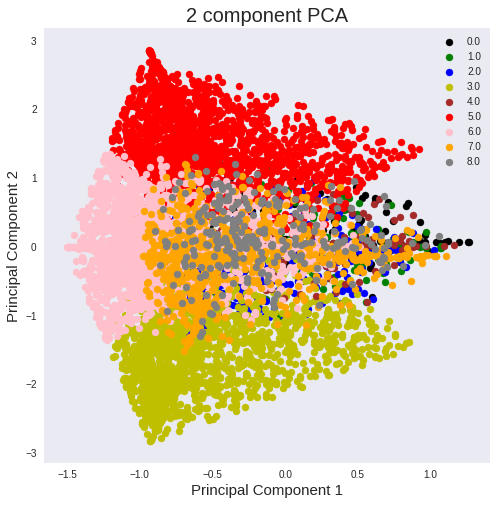

In [90]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['black', 'g', 'b', 'y', 'brown', 'red', 'pink', 'orange', 'grey']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'pc_1']
               , principalDf.loc[indicesToKeep, 'pc_2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Otro método: Non-negative Matrix Factorization (NMF)

A continuación, utilizaremos el modelo NMF para generar recomendaciones:

In [91]:
n_components = 10
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Tópico #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()
    print()


data_samples = corpus_df['abstract'].values

# Formato TF-IDF de sklearn
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Fit NMF
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5,
          ).fit(tfidf)
nmf_transform_1 = nmf.transform(tfidf)
# Display NMF
print("Tópicos:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)
print()
print()

# Fit NMF with KL-Divergence
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5,
          ).fit(tfidf)
# Display NMF with KL-Divergence
print("Tópicos con divergencia KL:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)
print()
print()

Tópicos:
Tópico #0: algorithm problem algorithms problems model method set paper results methods number search based models approach new used space using graph

Tópico #1: logic language programming type semantics languages programs program calculus proof theory types order specification reasoning functional temporal knowledge properties logics

Tópico #2: software systems parallel memory performance design distributed applications application code paper architecture support user hardware development level communication implementation process

Tópico #3: data query web information database queries databases retrieval documents xml relational text user sources document semantic knowledge mining search access

Tópico #4: agents agent planning mobile autonomous actions environment information action robot plan multi behavior negotiation plans coordination cooperative control intelligent interaction

Tópico #5: image images motion video shape camera recognition visual based 3d tracking vis

**Pregunta:** ¿Le parece significativa la diferencia en la calidad de los tópicos al usar la divergencia KL? ¿Son mejores estos tópicos que los obtenidos anteriormente?

**Respuesta:** Los tópicos obtenidos son mucho mejores a los encontrados anteriormente, en ellos casi no hay rastro de palabras ambigüas, a excepción de algunos verbos que permanecen sin jugar un papel fundamental en la diferenciación de temas. Por otro lado, las palabras que encontramos sí otorgan cierto sentido particular o al menos, denotan un tema en común, cosa que aún al usar lda sin stop words no se lograba del todo.

Agregamos los valores obtenidos como una columna en el *dataframe*:

In [94]:
corpus_df['NMF'] = [[(i, prob) for i, prob in enumerate(l)] for l in nmf_transform_1.tolist()]

corpus_df['NMF'][0]

[(0, 0.017552312942651277),
 (1, 0.0),
 (2, 0.00024942073208881885),
 (3, 0.0),
 (4, 0.0),
 (5, 0.016201010036704863),
 (6, 0.0),
 (7, 0.001184297742430841),
 (8, 0.0),
 (9, 0.0)]

**Pregunta:** Explique qué representa la columna `NMF`, ¿qué significan los valores?

**Respuesta:** Nuevamente MMF entrega una distribución por tema que compone cada uno de los documentos, donde se indexa los 10 tópicos encontrados con su respectiva probabilidad de que este se haya generado a partir de la consideración de este.

Repetimos el proceso de *sampling* para inspeccionar los resultados:

In [95]:
# Rellocate user

samples = corpus_df.iloc[samples_ids]

for n, (ix, paper) in enumerate(samples.iterrows()):
    idx, title, abstract, bow, tf_idf, lda, bow_without_stopwords, tf_idf_without_stopwords, lda_without_stopwords, nmf = paper[[
        'id', 'title', 'abstract', 'bow', 'tf_idf', 'lda', 'bow_without_stopwords', 'tf_idf_without_stopwords', 'lda_without_stopwords', 'NMF']]
    print('%d) %s' % (n+1, title))
    print('')
    print("\n".join(wrap(abstract)))
    print('\n')

1) Generative Model-based Clustering of Directional Data

High dimensional directional data is becoming increasingly important
in contemporary applications such as analysis of text and gene-
expression data. A natural model for multivariate directional data is
provided by the von Mises-Fisher (vMF) distribution on the unit
hypersphere that is analogous to the multi-variate Gaussian
distribution in R . In this paper, we propose modeling complex
directional data as a mixture of vMF distributions. We derive and
analyze two variants of the Expectation Maximization (EM) framework
for estimating the parameters of this mixture. We also propose two
clustering algorithms corresponding to these variants. An interesting
aspect of our methodology is that the spherical kmeans algorithm
(kmeans with cosine similarity) can be shown to be a special case of
both our algorithms. Thus, modeling text data by vMF distributions
lends theoretical validity to the use of cosine similarity which has
been widely

**Pregunta:** Compare y comente sobre las recomendaciones hechas por los métodos anteriores con las obtenidas usando NMF.

**Respuesta:** Las recomendaciones son variadas entre los diferentes modelos, por esto mismo, es necesario mirar con detalle cuales son las sugerencias para afirmar cual algoritmo es el que se comporta mejor. Observando se puede ver td_idf con NMF son los que más se parecen, logrando en algunas publicaciones coincidar hasta en dos recomendaciones similares, por su parte lda es el que muestra una mayor gamma de opciones. Cuando observamos en particular el paper "The Role of Context in Question Answering Systems" y las recomendaciones que se nos hacen al respecto, se aprecia que td-idf es el único capaz de rescatar una real similaridad temática (Question Answering) en los paper sugeridos, por su parte, el método NMF tiende a perderse dándole importancia quizá a otros aspectos o fundamentando una similaridad temática más amplia (computación).

In [99]:
doc_idx = make_recommendations('lda_without_stopwords', 'euclidean', 5)
print_recommendations(doc_idx, 'lda_without_stopwords')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Expectation Maximization for Clustering on Hyperspheres
2. Support Vector Machine Prediction Of Signal Peptide Cleavage Site
3. Active Shape Model Search using Local Grey-Level Models: A Quantitative Evaluation
4. On Training Neural Nets through Stochastic Minimization
5. A Family of Algorithms for Finding Temporal Structure in Data


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Burg --- Fast Optimal Instruction Selection and Tree Parsing
2. Improving Interactive Information Retrieval Effectiveness with 3-D Graphics
3. Visualising Multiple Overlapping Classification Hierarchies
4. On The Relationship Between Abduction And Deduction
5. A Power Model for Routers: Modeling Alpha 21364 and InfiniBand Routers


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Authenticated Data Structures for Graph and Geometric Searching
2. Overview of the TREC-9 Question Answeri

In [101]:
doc_idx = make_recommendations('tf_idf_without_stopwords', 'euclidean', 5)
print_recommendations(doc_idx, 'tf_idf_without_stopwords')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Expectation Maximization for Clustering on Hyperspheres
2. Modeling Data using Directional Distributions
3. Iterative Clustering of High Dimensional Text Data Augmented by Local Search
4. Clustering Binary Data Streams with K-means
5. Unsupervised Classification with Non-Gaussian Mixture Models using ICA


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. Overview of the TREC-9 Question Answering Track
2. Text Segmentation by Topic
3. Probabilistic Question Answering on the Web
4. Web Question Answering: Is More Always Better?
5. AskMSR: Question Answering Using the Worldwide Web


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Updates for Structure Indexes
2. Covering Indexes for Branching Path Queries
3. Efficient Peer-To-Peer Searches Using Result-Caching
4. On Implementing a Language for Specifying Active Database Execution Models
5. A Functional Database




In [96]:
doc_idx = make_recommendations('NMF', 'euclidean', 5)
print_recommendations(doc_idx, 'NMF')

Generative Model-based Clustering of Directional Data

Documentos cercanos: 
1. Data Exchange: Getting to the Core
2. Expectation Maximization for Clustering on Hyperspheres
3. Modeling Data using Directional Distributions
4. Search and Ranking Algorithms for Locating Resources on the World Wide Web
5. On Comparing Classifiers: A Critique of Current Research and Methods


The Role of Context in Question Answering Systems

Documentos cercanos: 
1. An Automated System for Web Portal Personalization
2. World Wide Web Implementation of the Langley Technical Report Server
3. Translating Web Data
4. The WWW Based Data Mining Toolbox Architecture
5. Automatic Generation of Warehouse Mediators Using an Ontology Engine


AutoAdmin What-if Index Analysis Utility

Documentos cercanos: 
1. Query Processing for High-Volume XML Message Brokering
2. The KDD Process for Extracting Useful Knowledge from Volumes of Data
3. STREAM: The Stanford Stream Data Manager
4. Indexing Open Schemas
5. A Meta-Wrapp